In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("E-commerce cosmetic dataset.csv",encoding="latin1")
df_geo = pd.read_csv('brand_geo.csv')
df_geo.head(3)

,brand,brand_geo
0,Carlton London,other
1,Charlene,other
2,Denver,other


In [3]:
def sizeclean(point):
    if type(point)==str:
        point=point.split(" ")[0]
        point=float(point)
    return point

In [4]:
df['size']=df['size'].apply(sizeclean)

In [5]:
# Convert the 'size' column to numeric, forcing errors to NaN
df['size'] = pd.to_numeric(df['size'], errors='coerce')

In [6]:
# Fill 'No type' for records with blank type value
df['type'] = df['type'].fillna('No type')
# Group by 'category' & 'subcategory' and fill NaN values with the mean of the group
df['size_cv'] = df.groupby(['category','subcategory'])['size'].transform(lambda x: x.fillna(x.mean()))
df['price_cv'] = df.groupby(['category','subcategory'])['price'].transform(lambda x: x.fillna(x.mean()))
df.isna().sum()

product_name       0
website            0
country            0
category           0
subcategory        0
title-href         0
price            317
brand              0
ingredients     6015
form               0
type               0
color           1989
size            3166
rating          2067
noofratings      459
size_cv            0
price_cv           0
dtype: int64

In [7]:
df.shape

(12615, 17)

Text(0.5, 1.0, 'Size_cv by Category')

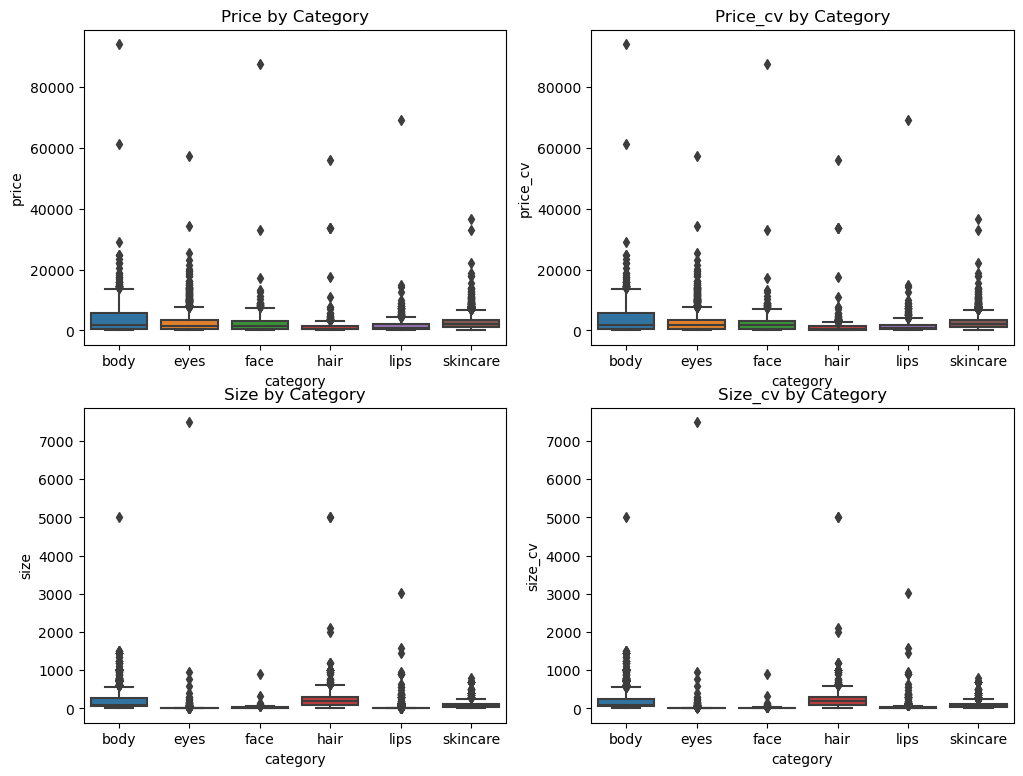

In [8]:
# check if the value after imputed with mean still have the same distribution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
sns.boxplot(ax=axes[0,0],x='category', y='price', data=df).set_title('Price by Category')
sns.boxplot(ax=axes[0,1],x='category', y='price_cv', data=df).set_title('Price_cv by Category')
sns.boxplot(ax=axes[1,0],x='category', y='size', data=df).set_title('Size by Category')
sns.boxplot(ax=axes[1,1],x='category', y='size_cv', data=df).set_title('Size_cv by Category')

**Option 2: Classify brand/product class by price percentile in each category**

In [9]:
# Function to classify based on percentiles
def classify_price(x):
    if x <= 0.6:
        return 'Regular'
    elif x <= 0.95:
        return 'Premium'
    else:
        return 'Super Premium'

In [10]:
# The groupby method is used to group the DataFrame by the brand column.
# The transform method along with rank(pct=True) calculates the percentile rank for each price within its brand group
df['percentile'] = df.groupby('category')['price_cv'].transform(lambda x: x.rank(pct=True))
df['brand'] = df['brand'].astype(str).str.strip().str.lower()
df['product_class'] = df['percentile'].apply(classify_price)

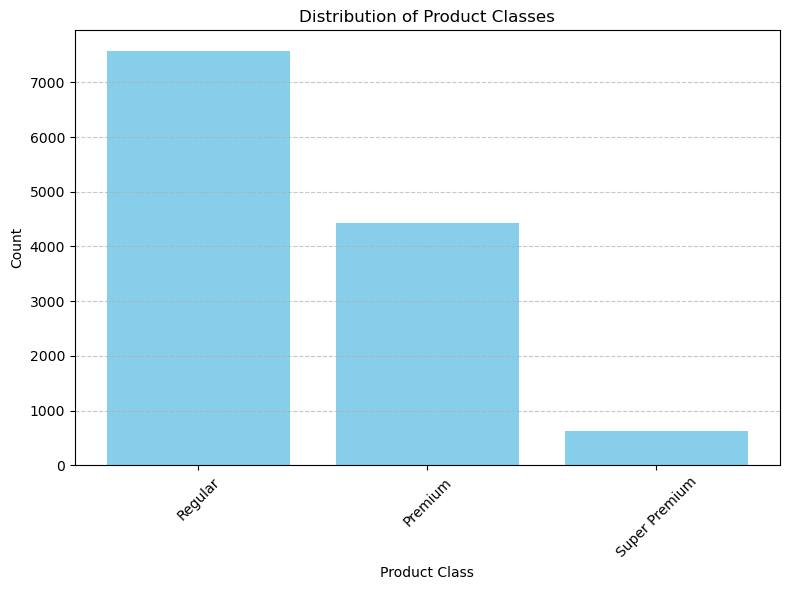

In [11]:
# Create a count plot (bar chart)
plt.figure(figsize=(8, 6))
plt.title('Distribution of Product Classes')
plt.xlabel('Product Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the counts
plt.bar(df['product_class'].value_counts().index, df['product_class'].value_counts().values, color='skyblue')

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
# Group by brand and product_class, and count occurrences
product_class_counts = df.groupby(['brand', 'product_class']).size().reset_index(name='count')

# Find the product class with the maximum count for each brand
max_product_class = product_class_counts.loc[product_class_counts.groupby('brand')['count'].idxmax()]

# Reset index for the final DataFrame
max_product_class = max_product_class.reset_index(drop=True)
max_product_class.rename(columns={'product_class':'brand_class'}, inplace=True)
# print(max_product_class.shape, df.brand.nunique())
# max_product_class.head(3)

In [13]:
df = df.merge(max_product_class[['brand', 'brand_class']], on = 'brand', how = 'left')
df.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings,size_cv,price_cv,percentile,product_class,brand_class
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,carlton london,NaN,aerosol,No type,"Top Note: Orange Blossom, Blackberry | Heart N...",100.0,3.9,19,100.0,599.0,0.257926,Regular,Regular
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,charlene,NaN,aerosol,No type,Unit count type:,30.0,4.4,"4,031",30.0,149.0,0.030528,Regular,Regular
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,charlene,NaN,aerosol,No type,Unit count type:,30.0,4.4,"4,072",30.0,298.0,0.120352,Regular,Regular
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,denver,NaN,aerosol,No type,Long-Lasting Scent,60.0,4.2,61,60.0,245.0,0.087084,Regular,Regular
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,denver,NaN,aerosol,No type,Long-Lasting Scent,100.0,4.3,342,100.0,422.0,0.194912,Regular,Regular


**rating/noofratings Column Transform:**  if noofratings is blank & rating >10, then rating is noofratings. For the rest impute missing values using mean/median of the sub-category

In [14]:
df['rating'] = df['rating'].str.split(" ").str[0]
df['rating'] = df['rating'].str.replace(',', '')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
incorrect_ratings = df['rating'] > 10
df.loc[incorrect_ratings, 'noofratings'] = df.loc[incorrect_ratings, 'rating']
df.loc[incorrect_ratings, 'rating'] = 0

In [15]:
def ratingno(point):
    if point in ('Write A Review','No reviews','New to Amazon'):
        point = 0
    elif type(point)==str:
        point=point.split(" ")[0]
        point=point.replace(",","")
        point=float(point)
    return point
df['noofratings_cv']=df['noofratings'].apply(ratingno)

In [16]:
df['rating'] = df.groupby('subcategory')['rating'].transform(lambda x: x.fillna(x.mean()).mask((x == 0) | (x > 5), x.mean()))
df['rating'] = df['rating'].round(1)

In [17]:
df['brand'] = df['brand'].str.upper()
df_geo['brand'] = df_geo['brand'].str.upper()
df = df.merge(df_geo, on = 'brand', how = 'left')
df.to_csv('df_transformed.csv')
df.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,size,rating,noofratings,size_cv,price_cv,percentile,product_class,brand_class,noofratings_cv,brand_geo
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,CARLTON LONDON,NaN,aerosol,...,100.0,3.9,19,100.0,599.0,0.257926,Regular,Regular,19.0,other
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,CHARLENE,NaN,aerosol,...,30.0,4.4,"4,031",30.0,149.0,0.030528,Regular,Regular,4031.0,other
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,CHARLENE,NaN,aerosol,...,30.0,4.4,"4,072",30.0,298.0,0.120352,Regular,Regular,4072.0,other
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,DENVER,NaN,aerosol,...,60.0,4.2,61,60.0,245.0,0.087084,Regular,Regular,61.0,other
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,DENVER,NaN,aerosol,...,100.0,4.3,342,100.0,422.0,0.194912,Regular,Regular,342.0,other


In [18]:
print(df.shape)
df.isna().sum()

(12615, 22)


product_name         0
website              0
country              0
category             0
subcategory          0
title-href           0
price              317
brand                0
ingredients       6015
form                 0
type                 0
color             1989
size              3166
rating             674
noofratings        405
size_cv              0
price_cv             0
percentile           0
product_class        0
brand_class          0
noofratings_cv     405
brand_geo            2
dtype: int64

In [19]:
df[df['product_name']=='Lakme Insta Eye Liner, Black Semi_Matte Finish, Water Resistant, Long-Lasting, 9 ']

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,size,rating,noofratings,size_cv,price_cv,percentile,product_class,brand_class,noofratings_cv,brand_geo
2986,"Lakme Insta Eye Liner, Black Semi_Matte Finish...",Amazon,India,eyes,eyeliner,https://www.amazon.in/Lakme-Insta-Eye-Liner-Bl...,130.0,LAKMÏ¿½,NaN,gel,...,NaN,4.1,38657,2.863233,130.0,0.010103,Regular,Regular,38657.0,local


**ML model on skincare ingredients importance**

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import re
import copy
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [52]:
# Create new dataframe on skincare category
df_skin = df[df['category']=='skincare'].dropna(subset=['ingredients']).reset_index(drop=True)
print(df_skin.shape)
df_skin.isna().sum()

(1676, 22)


product_name        0
website             0
country             0
category            0
subcategory         0
title-href          0
price               1
brand               0
ingredients         0
form                0
type                0
color             569
size                0
rating              0
noofratings         0
size_cv             0
price_cv            0
percentile          0
product_class       0
brand_class         0
noofratings_cv      0
brand_geo           0
dtype: int64

Price distribution by different attributes

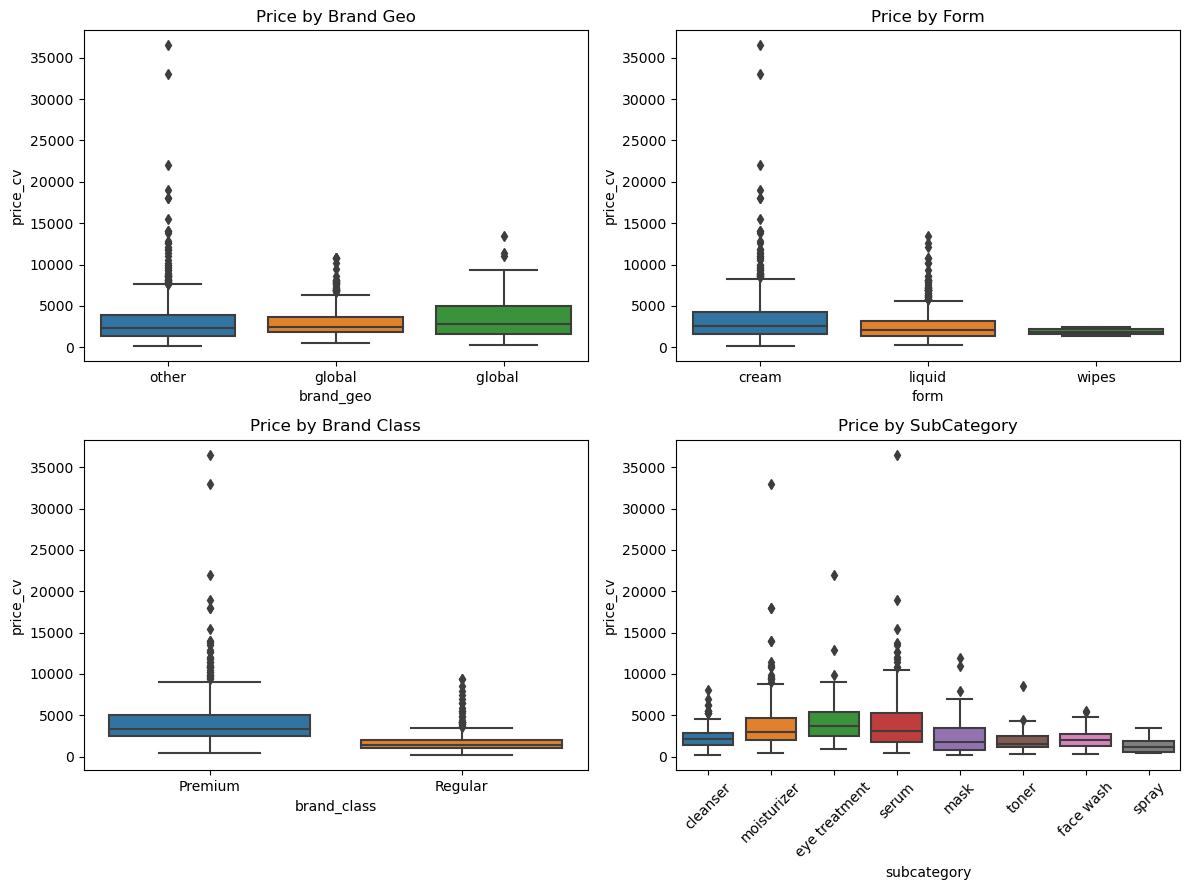

In [123]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
sns.boxplot(ax=axes[1,1],x='subcategory', y='price_cv', data=df_skin).set_title('Price by SubCategory')
sns.boxplot(ax=axes[0,1],x='form', y='price_cv', data=df_skin).set_title('Price by Form')
sns.boxplot(ax=axes[1,0],x='brand_class', y='price_cv', data=df_skin).set_title('Price by Brand Class')
sns.boxplot(ax=axes[0,0],x='brand_geo', y='price_cv', data=df_skin).set_title('Price by Brand Geo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Generate the train & test dataset

In [79]:
# Tokenize the ingredients column
vectorizer = CountVectorizer(token_pattern=r'\b[a-zA-Z]+\b', min_df=15, stop_words='english')
ingredients_matrix = vectorizer.fit_transform(df_skin['ingredients'])

# Create a DataFrame from the ingredients matrix
ingredients_df_skin = pd.DataFrame(ingredients_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the ingredients_df_skin with the original DataFrame
df_skin_ml = pd.concat([df_skin.drop(columns=['ingredients']), ingredients_df_skin], axis=1)

# Convert categorical variables to dummy/indicator variables
df_skin_ml = pd.get_dummies(df_skin_ml, columns=['subcategory', 'form', 'brand_class', 'brand_geo'],drop_first=True)

# Separate the dependent and independent variables
X = df_skin_ml.drop(columns=['product_name', 'price','price_cv','website','category','type','color',
                             'country','title-href','brand','size','noofratings','product_class','percentile'])
y = df_skin_ml['price_cv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

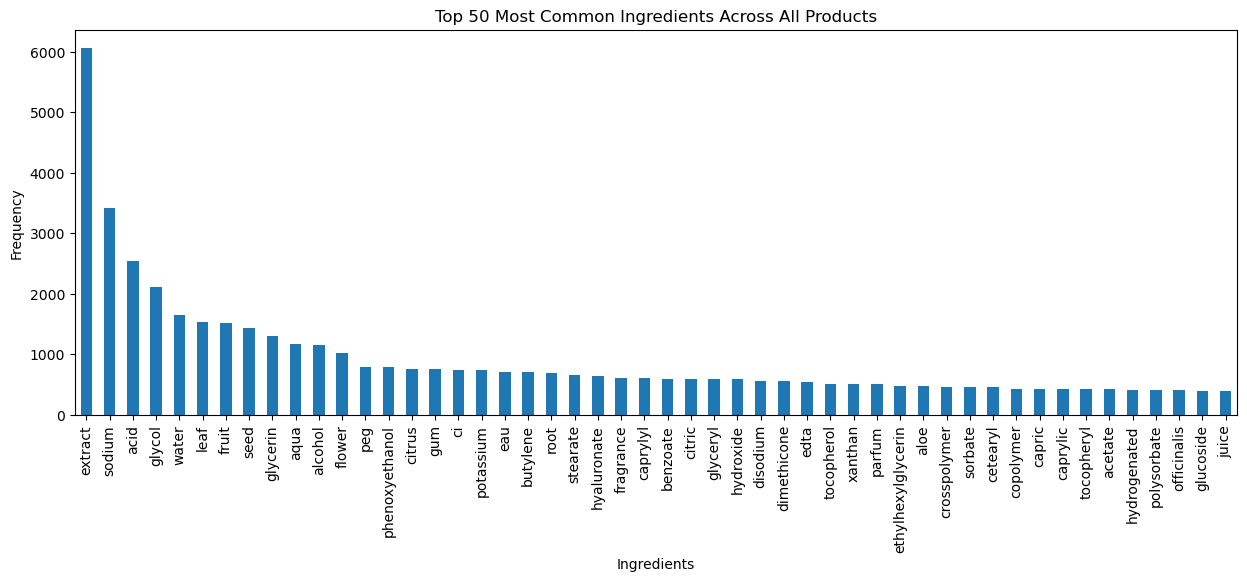

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 2. Bar Plot for Ingredient Frequency
ingredient_counts = ingredients_df_skin.sum().sort_values(ascending=False).head(50)
plt.figure(figsize=(15, 5))
ingredient_counts.plot(kind='bar')
plt.title("Top 50 Most Common Ingredients Across All Products")
plt.xlabel("Ingredients")
plt.ylabel("Frequency")
plt.show()

**Linear regression model with Lasso regularization**

Evaluate model performance with different alpha value

In [80]:
alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
train_rmses = []
test_rmses = []
train_r2s = []
test_r2s = []
complexity = []
coef_count = []
for a in alphas:
    # fit model with given alpha
    lasso = Lasso(alpha = a, max_iter=5000)
    lasso.fit(X_train, y_train)
    lasso_coef = lasso.coef_
    # predict the stars of train and test dataset
    y_pred_train = lasso.predict(X_train)
    y_pred_test = lasso.predict(X_test)
    # calculate RMSE of train and test dataset
    train_rmse = mean_squared_error(y_train, y_pred_train, squared = False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared = False)
    train_r2 = lasso.score(X_train, y_train)
    test_r2 = lasso.score(X_test, y_test)
    # append train rmse, test rmse and model complexity to list
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)
    complexity.append(sum(abs(lasso_coef)))
    coef_count.append(len(lasso_coef[lasso_coef!=0]))

In [81]:
lasso_model = pd.DataFrame({'alpha':alphas, 'Training RMSE':train_rmses, 
                            'Model Complexity': complexity, 'Test RMSE':test_rmses, 'Train R2': train_r2s,
                           'Test R2': test_r2, 'Coef count': coef_count})
lasso_model

,alpha,Training RMSE,Model Complexity,Test RMSE,Train R2,Test R2,Coef count
0,0.5,913.818401,257089.219595,2463.334577,0.843483,0.500736,677
1,0.6,929.043475,231481.553796,2435.382137,0.838224,0.500736,657
2,0.7,944.074537,209766.306342,2413.513882,0.832947,0.500736,641
3,0.8,957.343379,192880.486925,2396.130949,0.828218,0.500736,616
4,0.9,968.971290,179690.398775,2385.064024,0.824020,0.500736,600
5,1.0,979.759257,168612.032969,2376.409511,0.820079,0.500736,586


Lasso model with alpha = 1 has the highest R squared for test set & lowest model complexity. Hence this is selected as the best model. We proceed with model result as below.

In [82]:
model = Lasso(alpha=1,max_iter=3000)
model.fit(X_train, y_train)

# Print the coefficients
df_coef = pd.DataFrame({'feature':X.columns,'coef':model.coef_})
df_coef.to_csv('lasso_coef_1.csv')
coefficients = pd.Series(model.coef_, index=X.columns)
print('Train R squared: ',model.score(X_train,y_train), '\nTest R squared: ',model.score(X_test,y_test))

Train R squared:  0.8200792336592546 
Test R squared:  0.5007362781287858
